# Exploratory Data Analysis (EDA) on Dental X-ray Dataset
This notebook performs both basic and advanced exploratory data analysis (EDA) on the dental X-ray dataset. The dataset is loaded from a COCO-format JSON file, which includes segmentation masks encoded in RLE and other relevant information.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

In [2]:
# Load the COCO JSON file
with open('coco_dataset.json') as f:
    coco_data = json.load(f)

# Convert COCO data to pandas DataFrame for images
images_df = pd.DataFrame(coco_data['images'])

# Convert COCO data to pandas DataFrame for annotations
annotations_df = pd.DataFrame(coco_data['annotations'])

# Convert COCO data to pandas DataFrame for categories
categories_df = pd.DataFrame(coco_data['categories'])

# Merge annotations with category names
annotations_df = annotations_df.merge(categories_df[['id', 'name']], left_on='category_id', right_on='id', suffixes=('', '_category'))
annotations_df.rename(columns={'name': 'category_name'}, inplace=True)


## 1. Basic Data Overview
Start by looking at the basic structure of the data. And some descriptive statistics

In [3]:
# Overview of images
print(images_df.head())
print(images_df.info())

# Descriptive statistics for images
print(images_df.describe())

                          id                                  file_name  \
0  cl9zlwmzg12ma08b42nq122tp   IOP's/lopa_1_jpg_quality/IOPA (5874).jpg   
1  cl9zlwmzg12me08b4hhli1zd8   IOP's/lopa_1_jpg_quality/IOPA (6037).jpg   
2  cl9zlwmzg12mi08b41wsm2e70   IOP's/lopa_1_jpg_quality/IOPA (2645).jpg   
3  cl9zlwmzg12mm08b49ioi3s66   IOP's/lopa_1_jpg_quality/IOPA (5873).jpg   
4  cl9zlwmzg12mq08b4eh1a4xxh  IOP's/lopa_1_jpg_quality/IOPA (26659).jpg   

   height  width  
0     276    183  
1     197    256  
2     265    190  
3     194    259  
4     255    198  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23212 entries, 0 to 23211
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         23212 non-null  object
 1   file_name  23212 non-null  object
 2   height     23212 non-null  int64 
 3   width      23212 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 725.5+ KB
None
             height         width
co

In [24]:
# Overview of annotations
print(annotations_df.head())
print(annotations_df.info())

# Descriptive statistics for annotations
print(annotations_df.describe())


                          id                   image_id  category_id  \
0  clchi2m210001356j4rfwpipu  cl9zlwmzg12ma08b42nq122tp            1   
1  clchi4baa0005356j9jj7ydqr  cl9zlwmzg12ma08b42nq122tp            1   
2  clcq5lnwn0000356jke37eadh  cl9zlwmzg12me08b4hhli1zd8            2   
3  clblos0t10007356iblw1uncz  cl9zlwmzg12mi08b41wsm2e70            3   
4  clchiaw5f0007356jb4by7wn0  cl9zlwmzg12mi08b41wsm2e70            1   

                                        segmentation  area  iscrowd  \
0  {'counts': 'g_e0R1b7P1POK5J5L5J6K5K5J6K5J5L5J6...   483        0   
1  {'counts': 'iW4c0c0HT6f1L3M4L4L00ZOf0K5K5K5M3M...   763        0   
2  {'counts': 'PY6;g57K3M2M4M2M3O1N1O2N1N3O0O2N2O...  2559        0   
3  {'counts': 'iXl0V1S7M3M3N2M3M3O2O1O1O00001O002...   456        0   
4  {'counts': '[kk08Q88H3M4_H_OS7P1K3M3N1N2N2O1N3...   569        0   

                 bbox  id_category           category_name  
0   [79, 201, 14, 68]            1               Bone Loss  
1   [15, 193, 17, 

### 1.1. Class Distribution
Understand the distribution of different categories in the dataset.

name
Bone Loss                 51632
Restorations              26575
Type of Dentition         22576
Periapical Abnormality    14001
Prosthetics               10872
Dental Caries             10797
Absent Tooth               9093
Correct X-ray              6757
Implants                   5678
other                      3890
Impacted Tooth             1982
Attrition                   984
Fracture                    746
Root Stump                  733
Altered Morphology          443
Position                    224
Microdontia                   3
Name: count, dtype: int64


<Axes: title={'center': 'Category Distribution'}, xlabel='name'>

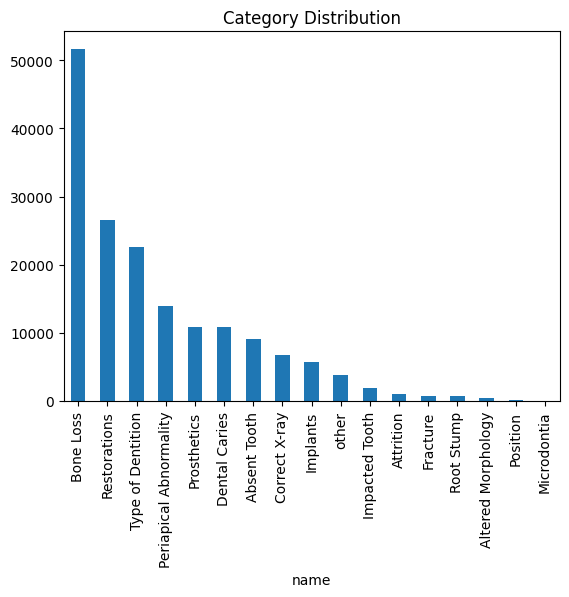

In [7]:
# Category distribution
category_counts = annotations_df['category_name'].value_counts()
print(category_counts)

# Visualize the distribution
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', title='Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

### 1.2. Image Size Distribution
Analyze the distribution of image dimensions.

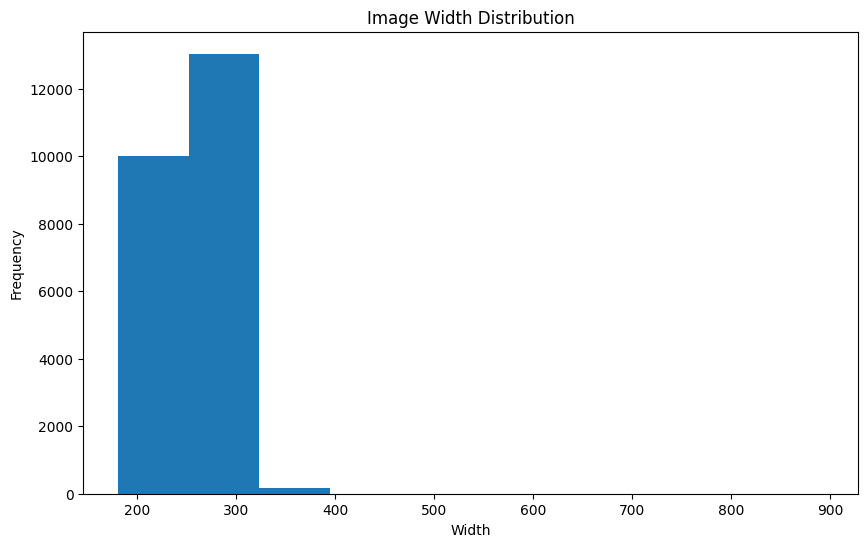

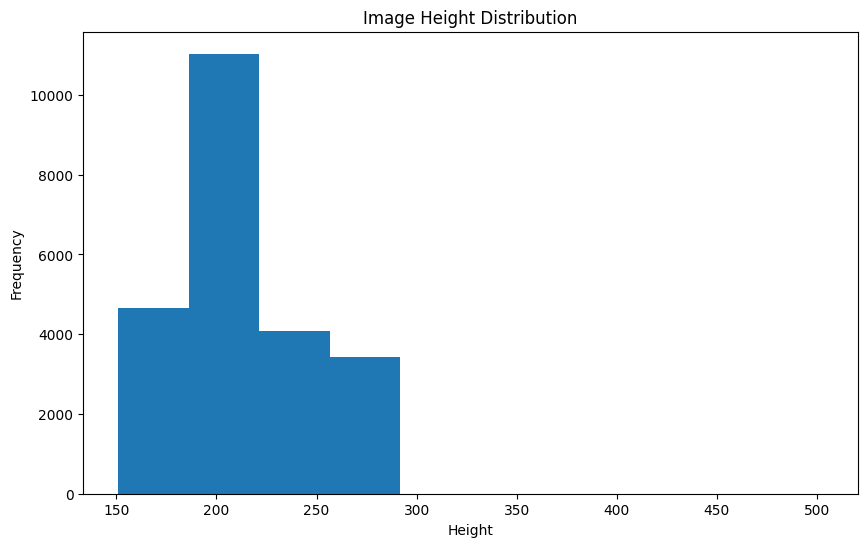

In [4]:
# Distribution of image widths
plt.figure(figsize=(10, 6))
images_df['width'].plot(kind='hist', title='Image Width Distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.show()

# Distribution of image heights
plt.figure(figsize=(10, 6))
images_df['height'].plot(kind='hist', title='Image Height Distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.show()


### 1.3. Segmentation Area Distribution
We will analyze the distribution of segmentation areas.

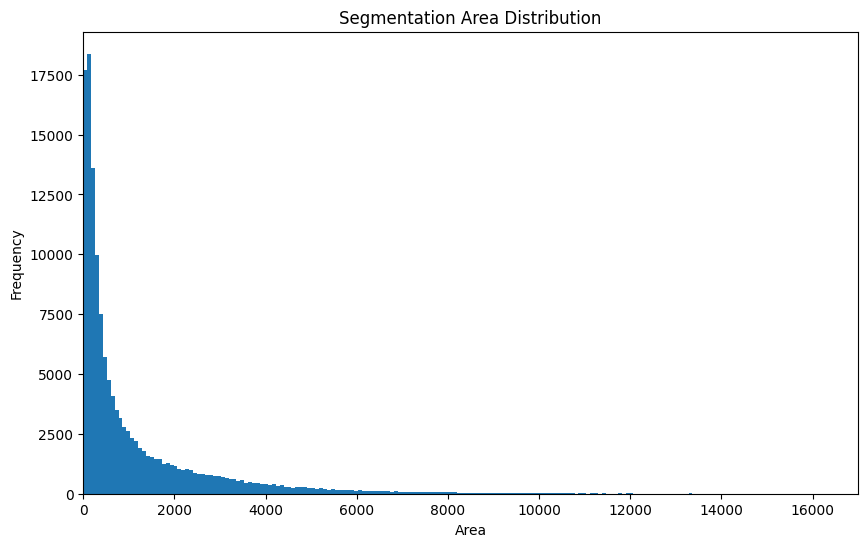

In [22]:
## Distribution of segmentation areas
plt.figure(figsize=(10, 6))
annotations_df['area'].plot(kind='hist', title='Segmentation Area Distribution', bins= 1000)
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.xlim(0, 17000) 
plt.show()

### 1.4. Correlation Analysis
We'll check the correlations between different variables, such as image dimensions and segmentation areas.

            area     width    height
area    1.000000 -0.054239  0.096712
width  -0.054239  1.000000 -0.941636
height  0.096712 -0.941636  1.000000


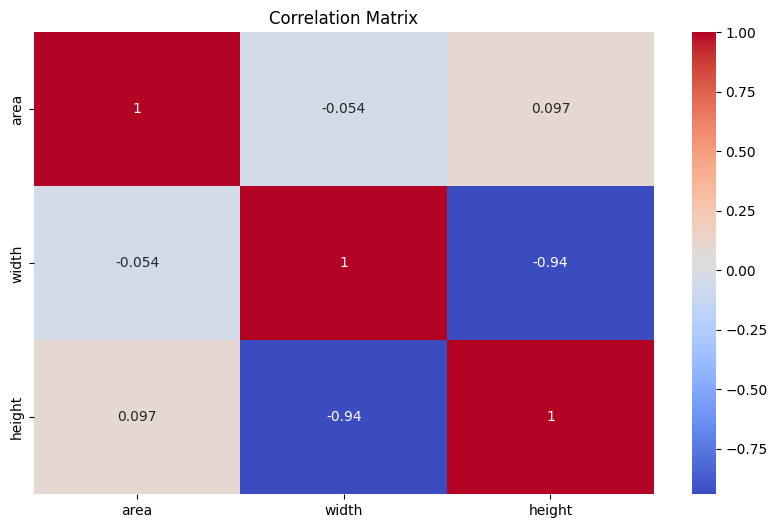

In [25]:
# Merge annotations with image dimensions
merged_df = annotations_df.merge(images_df[['id', 'width', 'height']], left_on='image_id', right_on='id', how='left')

# Correlation matrix for segmentation area and image dimensions
correlation_matrix = merged_df[['area', 'width', 'height']].corr()

# Display the correlation matrix
print(correlation_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## 2. Advanced EDA
In this section, we will perform advanced exploratory data analysis, including clustering, outlier detection, and PCA.



### 2.1. Clustering Analysis
We will apply K-Means clustering to group images based on their dimensions and the number of annotations.

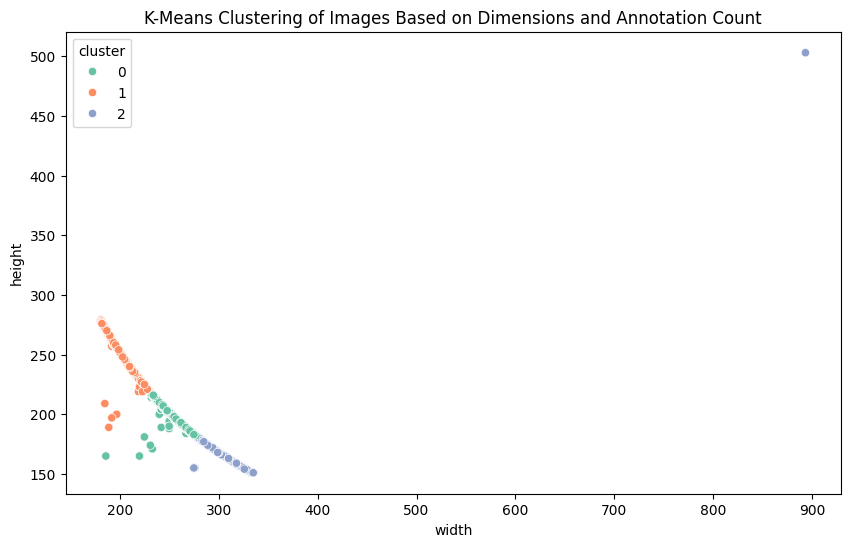

In [27]:
# Prepare the data for clustering
image_clustering_df = images_df[['width', 'height']].copy()
image_clustering_df['annotation_count'] = annotations_df.groupby('image_id')['id'].count().reindex(images_df['id']).fillna(0).values

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
image_clustering_df['cluster'] = kmeans.fit_predict(image_clustering_df)

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='width', y='height', hue='cluster', data=image_clustering_df, palette='Set2')
plt.title('K-Means Clustering of Images Based on Dimensions and Annotation Count')
plt.show()

### 2.2. Outlier Detection with Isolation Forest
We will use the Isolation Forest algorithm to detect outliers in the segmentation areas.

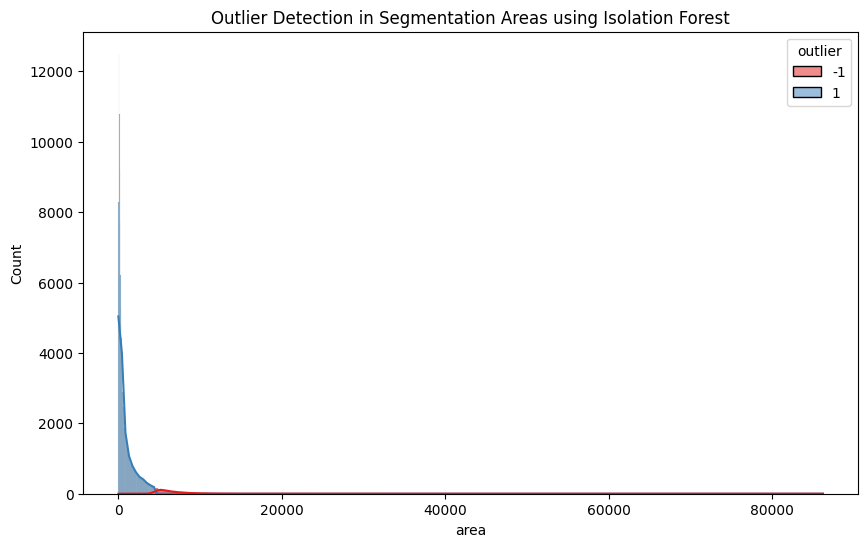

Number of normal points: 130779
Number of outliers: 6874


In [28]:
# Prepare the data for outlier detection
annotation_outlier_df = annotations_df[['area']].copy()

# Apply Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
annotation_outlier_df['outlier'] = iso_forest.fit_predict(annotation_outlier_df)

# Visualize the outliers
plt.figure(figsize=(10, 6))
sns.histplot(annotation_outlier_df, x='area', hue='outlier', palette='Set1', kde=True)
plt.title('Outlier Detection in Segmentation Areas using Isolation Forest')
plt.show()

# Show the number of outliers detected
outliers_count = annotation_outlier_df['outlier'].value_counts()
print("Number of normal points:", outliers_count[1])
print("Number of outliers:", outliers_count[-1])


### 2.3. Principal Component Analysis (PCA)
We will apply PCA to reduce the dimensionality of the dataset and visualize the main components.

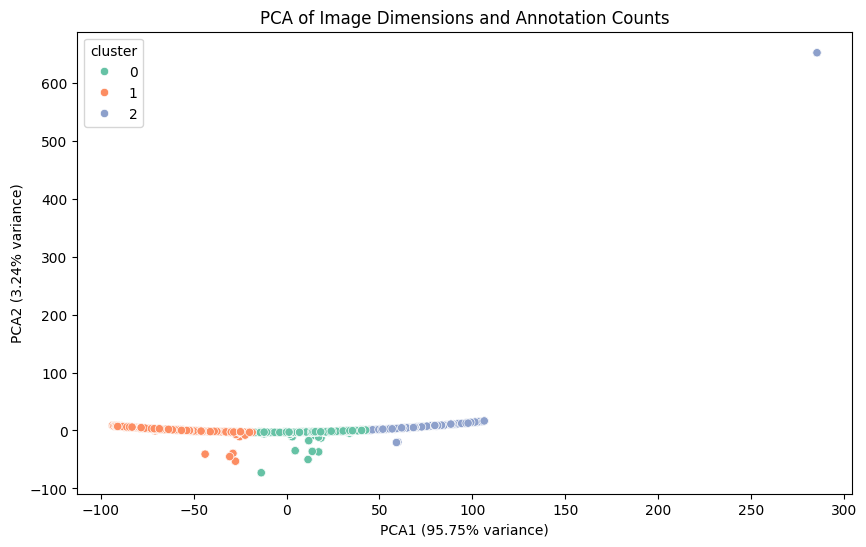

Explained variance by PCA1 and PCA2: [0.9574819  0.03241378]


In [29]:
# Prepare the data for PCA
pca_df = image_clustering_df[['width', 'height', 'annotation_count']]

# Apply PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(pca_df)

# Add PCA components to the dataframe
image_clustering_df['PCA1'] = pca_components[:, 0]
image_clustering_df['PCA2'] = pca_components[:, 1]

# Visualize the PCA components
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=image_clustering_df, palette='Set2')
plt.title('PCA of Image Dimensions and Annotation Counts')
plt.xlabel(f'PCA1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PCA2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.show()

# Print explained variance ratio
print("Explained variance by PCA1 and PCA2:", pca.explained_variance_ratio_)


## 3. Summary of Findings
Basic EDA:

- The basic analysis provided insights into the distribution of image sizes, segmentation areas, and categories in the dataset.
Correlation analysis showed the relationships between different variables, such as image dimensions and segmentation areas.

Advanced EDA:

- Clustering: K-Means clustering revealed distinct groups of images based on their dimensions and the number of annotations.
- Outlier Detection: The Isolation Forest algorithm identified potential outliers in the segmentation areas, which may represent rare cases or problematic annotations.
- PCA: Principal Component Analysis helped reduce the dataset to two main components, which explain the majority of variance in image dimensions and annotation counts.